# Regression Analysis on Student Grades

In [375]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sql

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression

from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectKBest, f_regression

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


## ETL / Database

### Connection parameters

In [284]:
db_params = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'password',
    'host': 'localhost',
    'port': '5432'
}

### Import data to SQL

In [438]:
do_sql = sql.create_engine(f'postgresql://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["dbname"]}')
try:
    df = pd.read_csv('data.csv', sep=';')
except:
    print('SQL import: file not found')
else:
    with do_sql.begin() as connection:
        df.to_sql("students", con=connection, index=False, if_exists='replace')

df.shape

(316, 33)

### Add Student Function

In [286]:
# Sample new student object
# This is passed as the argument to the add_student function

new_student = {             # Valid values
    'school': 'GP',         # B # 'GP' or 'MS'
    'sex': 'M',             # B # 'M' or 'F'
    'age': 24,              # N # any > 0
    'address': 'U',         # B # 'U' or 'R'
    'famsize': 'LE3',       # B # 'LE3' or 'GT3'
    'Pstatus': 'A',         # B # 'T' or 'A'
    'Medu': 3,              # N # 0 to 4
    'Fedu': 2,              # N # 0 to 4
    'Mjob': 'at_home',      # C # 'teacher', 'health', 'services', 'at_home', 'other'
    'Fjob': 'other',        # C # 'teacher', 'health', 'services', 'at_home', 'other'
    'reason': 'course',     # C # 'home', 'reputation', 'course', 'other'
    'guardian': 'father',   # C # 'mother', 'father', 'other'
    'traveltime': 3,        # N # 1 to 4
    'studytime': 2,         # N # 1 to 4
    'failures': 0,          # N # 1 to 4
    'schoolsup': 'no',      # B # 'yes' or 'no'
    'famsup': 'yes',        # B # 'yes' or 'no'
    'paid': 'no',           # B # 'yes' or 'no'
    'activities': 'yes',    # B # 'yes' or 'no'
    'nursery': 'yes',       # B # 'yes' or 'no'
    'higher': 'yes',        # B # 'yes' or 'no'
    'internet': 'yes',      # B # 'yes' or 'no'
    'romantic': 'yes',      # B # 'yes' or 'no'
    'famrel': 3,            # N # 1 to 5
    'freetime': 2,          # N # 1 to 5
    'goout': 2,             # N # 1 to 5
    'Dalc': 1,              # N # 1 to 5
    'Walc': 1,              # N # 1 to 5
    'health': 4,            # N # 1 to 5
    'absences': 1,          # N # 1 to 5
    'G1': 17,               # N # 0 to 20
    'G2': 18,               # N # 0 to 20
    'G3': 18                # N # 0 to 20
}

In [437]:

def add_student(new_student):
    # Open connection to database and instantiate cursor
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()

    try:
        # Insert statement inserts one comma-separated parameterized placeholder for every key in new_student object (column in database)
        insert_statement = f"""
        INSERT INTO students 
        VALUES ({', '.join((['%s']*len(new_student)))})
        """
        # Send insert statement; commit changes
        cursor.execute(insert_statement, list(new_student.values()))
        conn.commit()
    except (Exception, psycopg2.Error) as error:
        print("Error adding new student data:", error)
    finally:
        if conn:
            cursor.close()
            conn.close()

# add_student(new_student)


### Read up-to-date table from database for analysis

In [439]:
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

select_query = "SELECT * FROM students"
cursor.execute(select_query)

rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

df = pd.DataFrame(rows, columns=columns)

cursor.close()
conn.close()

df.shape


(316, 33)

## EDA

In [440]:
# Show info about each column: order, name, count, nulls, datatype
# print(df.info())

# # Display stats of numeric columns - count, mean, std, etc.
# print(df.describe())

# Check for null or duplicate entries
print('Total null entries:', df.isnull().sum().sum())
print(df.duplicated().value_counts())

# # If found:
# df = df.dropna().reset_index(drop=True)
# df = df.drop_duplicates(inplace=True)

Total null entries: 0
False    316
Name: count, dtype: int64


Thinking about categorical features and my assumptions.\
1 school - binary; no obvious ranking\
2 sex - binary; no obvious ranking\
4 address - binary (urban or rural); no obvious ranking\
5 famsize - binary (>3 or <=3); no obvious ranking\
6 Pstatus - binary (living together or apart); together better (e.g. more support?)\
7 Medu / 8 Fedu - mother's/father's education (ordinal, higher better)\
9 Mjob / 10 Fjob - mother's/father's job (nominal "teacher", "health", "services", "at_home", "other"); maybe advantage from "at_home" or "teacher"\
11 reason - reason to choose this school (nominal "home", "reputation", "course", "other"); maybe "reputation" or "course" suggest more interest in academics\
12 guardian - student's guardian (nominal: "mother", "father" or "other"); no obvious ranking. Given age range "other" may indicate adult student\
13 traveltime - home to school travel time (ordinal); higher worse\
14 studytime - weekly study time (ordinal); higher better\
16 schoolsup - extra educational support (binary); yes better\
17 famsup - family educational support (binary); yes better\
18 paid - extra paid classes within the course subject (binary); yes better\
19 activities - extra-curricular activities (binary); no obvious ranking\
20 nursery - attended nursery school (binary); yes better\
21 higher - wants to take higher education (binary); yes better\
22 internet - Internet access at home (binary); yes better\
23 romantic - with a romantic relationship (binary); no obvious ranking\
24 famrel - quality of family relationships (ordinal); higher better\
25 freetime - free time after school (ordinal); ambiguous\
26 goout - going out with friends (ordinal); higher worse\
27 Dalc - workday alcohol consumption (ordinal); higher worse\
28 Walc - weekend alcohol consumption (ordinal); higher worse\
29 health - current health status (ordinal); higher better

### Encoding categoricals right away
* Binary encoding should let me see distribution in one step and I'm going to do it anyway

In [441]:
# Encoding scheme 1: Binary then one-hot

# All binary values in the schema are unique! Nice.
# Try encoding binary columns
df_bin = df.copy()
df_bin.replace({
    'GP': 1, 'MS': 0,
    'M': 1, 'F': 0,
    'U': 1, 'R': 0,
    'LE3': 1, 'GT3': 0,
    'T': 1, 'A': 0,
    'yes': 1, 'no': 0
}, inplace=True)

# Generate one-hot columns of every remaining "object" column (nominal values)
df_dummies = pd.get_dummies(df_bin.select_dtypes(include='object'), dtype=int)

# Join new columns to dataset
df_oh = pd.concat([df_bin, df_dummies], axis=1)

# Drop "object" columns
df_oh = df_oh.drop(df_oh.select_dtypes(include='object').columns, axis=1)

df_oh.shape

# Visual inspection
# df_oh.to_csv('df_oh.csv', index=False)

(316, 46)

In [442]:
# Encoding scheme 2: Ordinalize everything

df_o = df.copy()

for colname in df_o.select_dtypes("object"):
    df_o[colname], _ = df_o[colname].factorize()

df_o.shape

# Visual inspection
# df_o.to_csv('df_o.csv', index=False)

(316, 33)

### Correlation matrices; table of target correlation

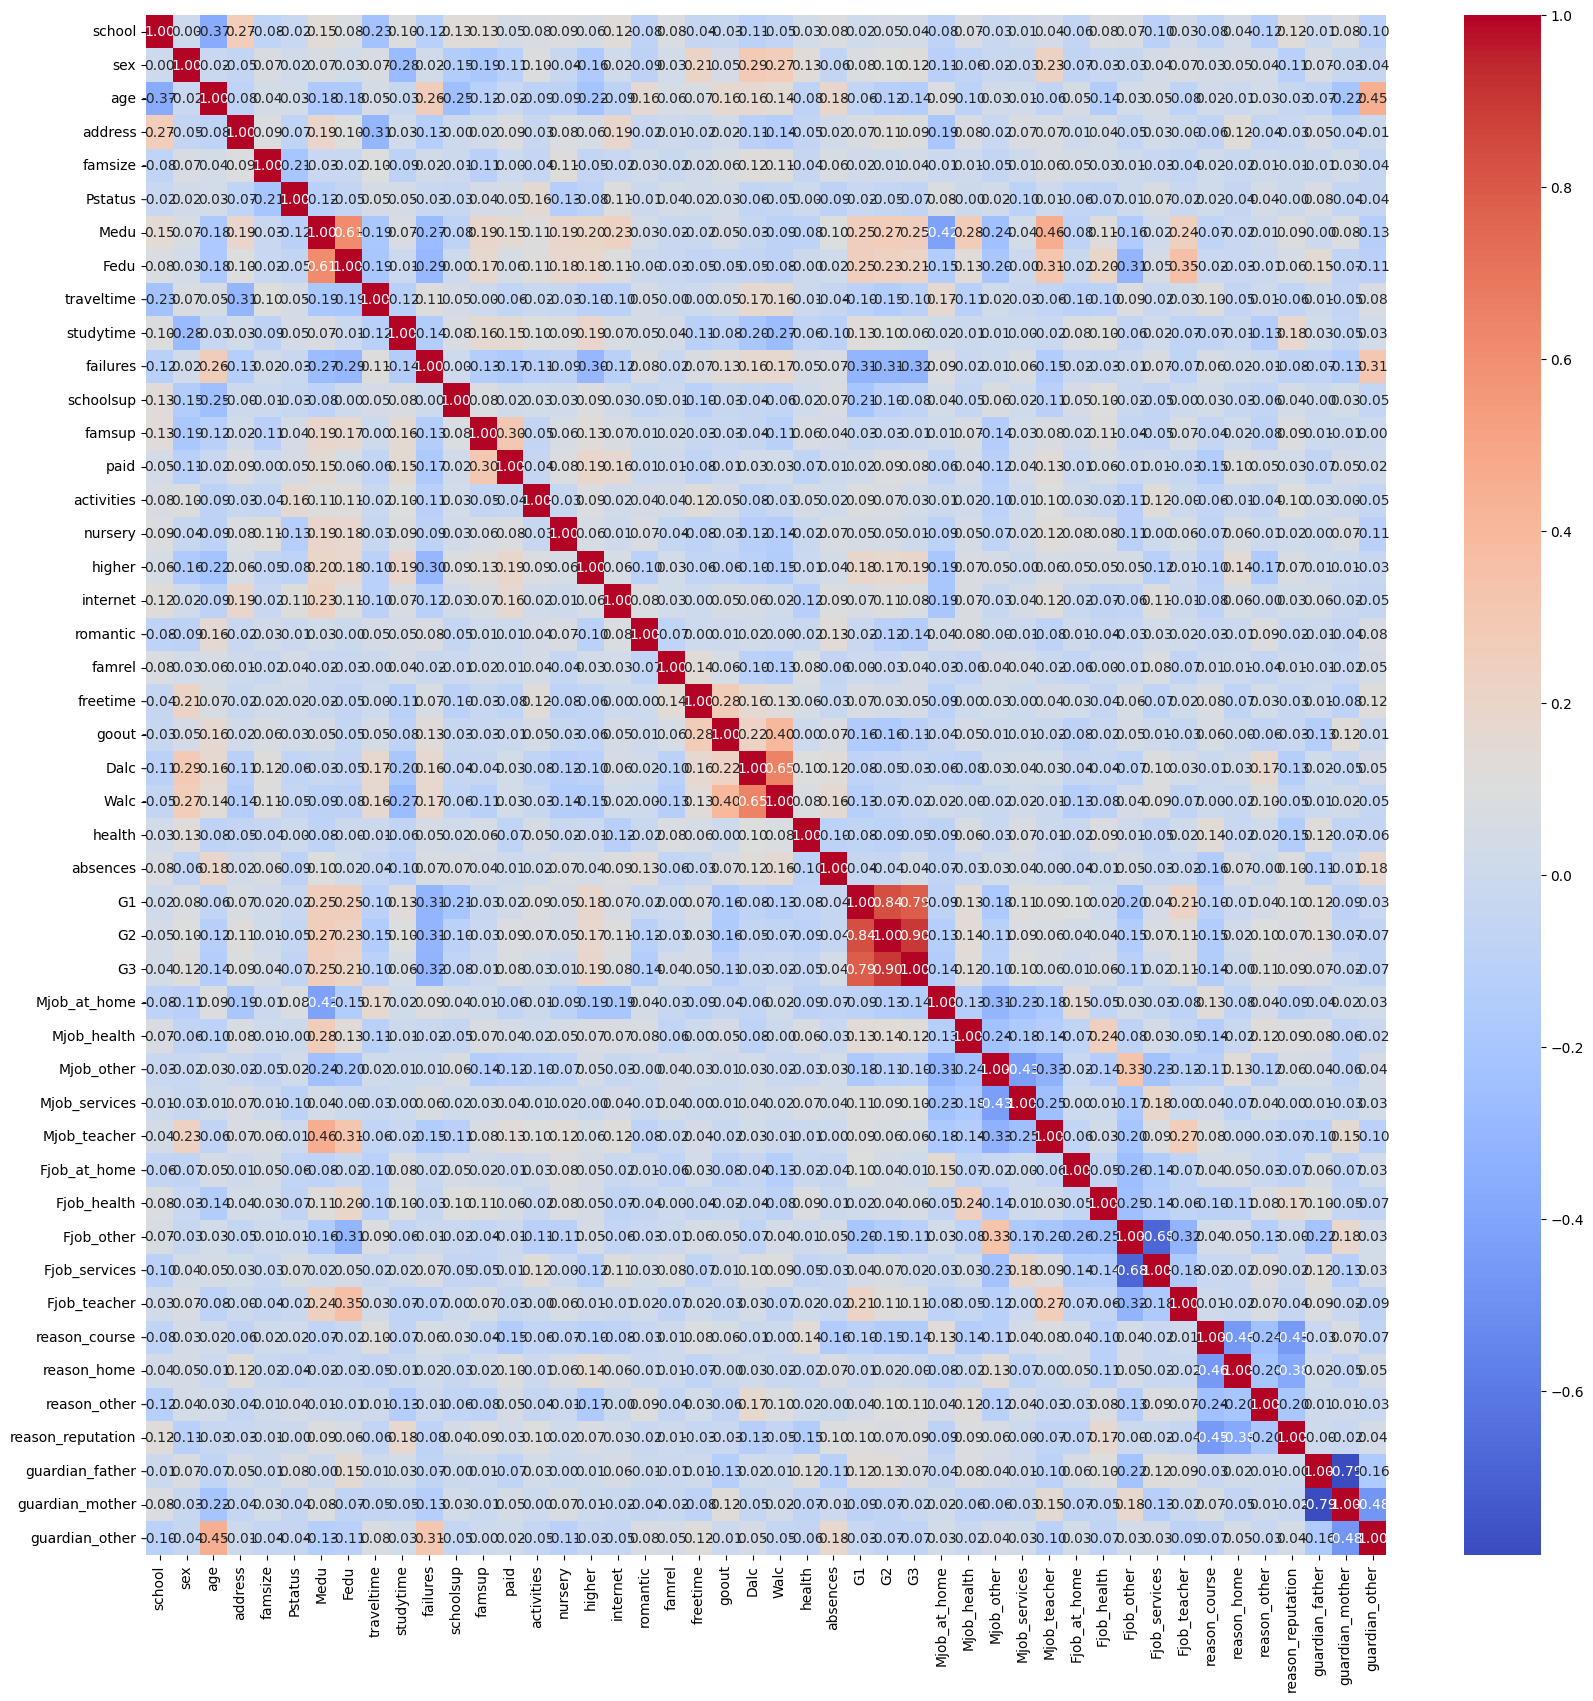

,G3 Correlation
G2,0.895996
G1,0.788582
failures,-0.317254
Medu,0.252612
Fedu,0.209600
higher,0.188371
reason_course,-0.142905
Mjob_at_home,-0.141693
romantic,-0.137925
age,-0.135614


In [443]:
# Encoding 1
corr_matrix_1 = df_oh.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix_1, cmap='coolwarm', annot=True, fmt=".2f") 
plt.show()

# Table of target correlation
ctarget = corr_matrix_1['G3'].drop('G3')
ctarget_table = pd.DataFrame({
    'G3 Correlation': ctarget,
    'abs': ctarget.abs()
})

ctarget_table = ctarget_table.sort_values(by='abs', ascending=False)
ctarget_table = ctarget_table.drop('abs', axis=1)

ctarget_table

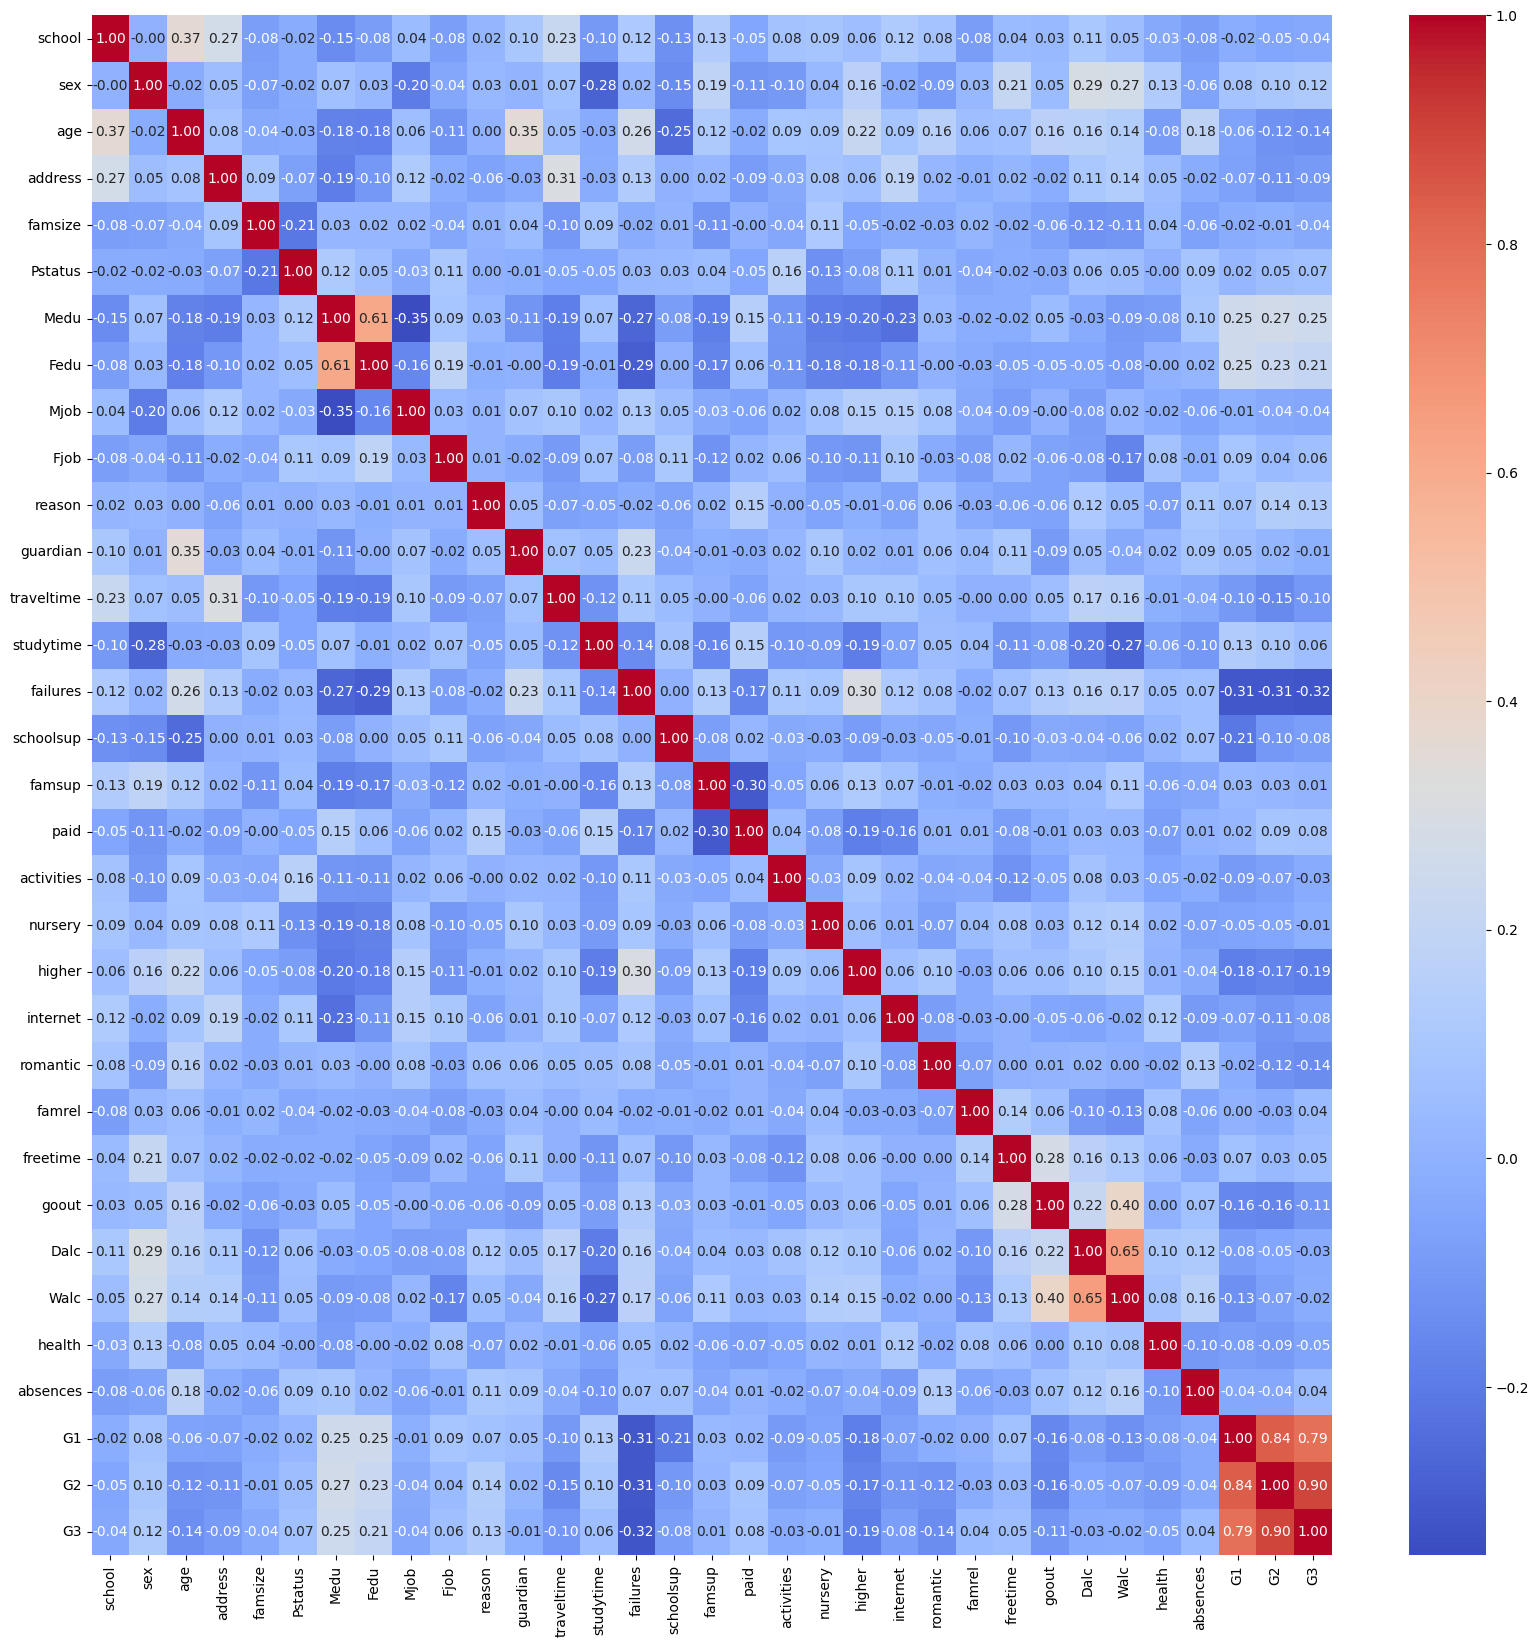

,G3 Correlation
G2,0.895996
G1,0.788582
failures,-0.317254
Medu,0.252612
Fedu,0.209600
higher,-0.188371
romantic,-0.137925
age,-0.135614
reason,0.130855
sex,0.117246


In [293]:
# Encoding 2
corr_matrix_2 = df_o.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix_2, cmap='coolwarm', annot=True, fmt=".2f") 
plt.show()

# Table of target correlation
ctarget = corr_matrix_2['G3'].drop('G3')
ctarget_table = pd.DataFrame({
    'G3 Correlation': ctarget,
    'abs': ctarget.abs()
})

ctarget_table = ctarget_table.sort_values(by='abs', ascending=False)
ctarget_table = ctarget_table.drop('abs', axis=1)

ctarget_table

Notes from correlation matrix:
* ONLY Prior period scores very strongly correlated with target
* Parent edu. levels somewhat correlated with target
* No. failures negatively correlated with target
* Slight negative correlation between going out more and target

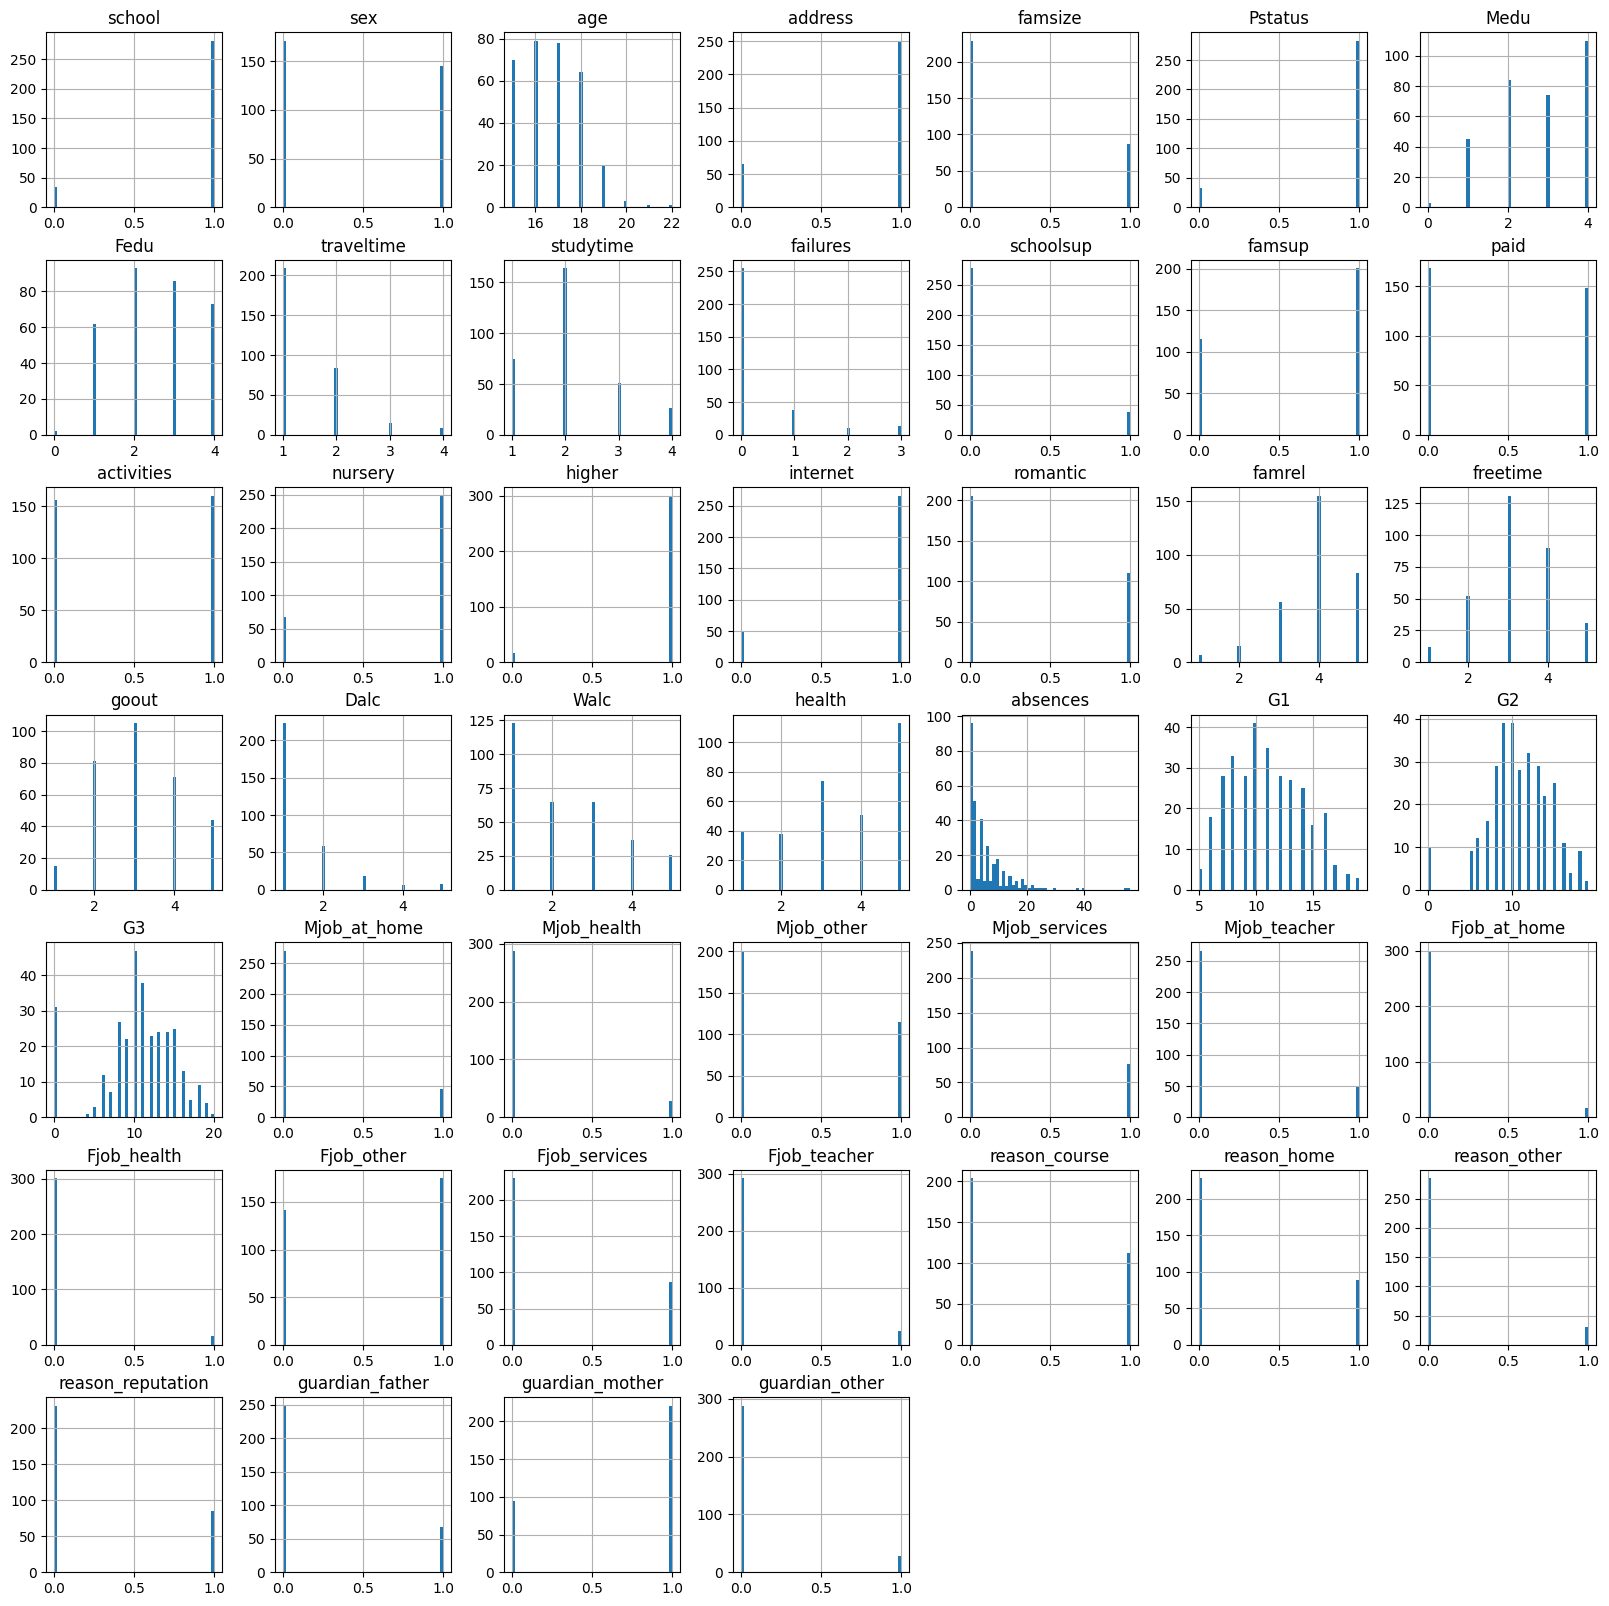

In [294]:
df_oh.hist(bins=50, figsize=(20,20))
plt.show()

* A lot of these binary features are low variance; might be droppable.

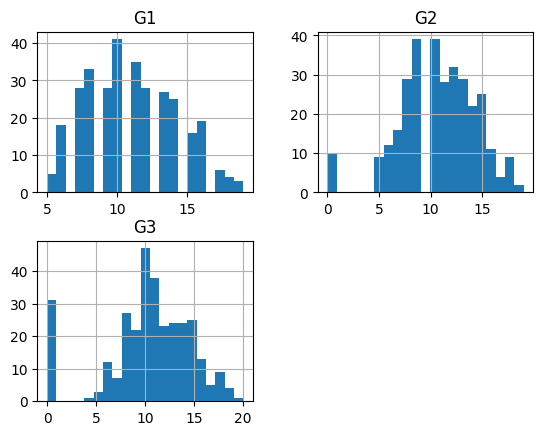

In [295]:
g1, g2, g3 = df_oh.G1, df_oh.G2, df_oh.G3
grades = pd.DataFrame({'G1': g1, 'G2': g2, 'G3': g3})
grades.hist(bins=21)
plt.show()

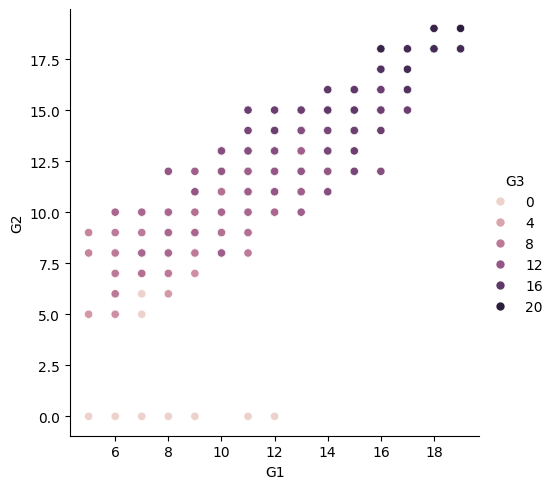

In [296]:
sns.relplot(x='G1', y='G2', hue='G3', data=df_oh)

In [297]:
# Mutual Information, encoding 1
Xmi = df_oh.copy()
ymi = Xmi.pop("G3")

len(Xmi.columns)
# Xmi.info()

mi_scores = mutual_info_regression(Xmi, ymi)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=Xmi.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Top 8: 
# G2                   1.373714
# G1                   0.776573
# absences             0.139622
# failures             0.135755
# Walc                 0.079728
# paid                 0.059358
# Mjob_health          0.051893
# Mjob_teacher         0.050363

# print(mi_scores)

# MI, encoding 2
Xo = df_o.copy()
yo = Xo.pop("G3")

mi_scores_o = mutual_info_regression(Xo, yo)
mi_scores_o = pd.Series(mi_scores, name="MI Scores", index=Xo.columns)
mi_scores_o = mi_scores.sort_values(ascending=False)

# Top 8:
# G2                   1.314377
# G1                   0.791916
# absences             0.181070
# goout                0.084070
# internet             0.072912
# failures             0.058035
# Mjob_at_home         0.046831
# Mjob_other           0.041441

# print(mi_scores_o)


#### Encoding not seeming to make a huge difference. Proceeding with encoding 1

## Train/Test Split

In [444]:
X = df_oh.copy()
y = X.pop('G3')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

## Model Function for Model Comparison

In [445]:
def try_models(desc, data, target, container):
    # This is round 2. Round 1 eliminated Lasso, Ridge, SVR (linear and rbf) and ElasticNet
    lr = LinearRegression()
    gbr = GradientBoostingRegressor(random_state=13)
    rfr = RandomForestRegressor(random_state=13)
    ests = [lr, gbr, rfr, VotingRegressor(estimators=[('rfr', rfr), ('gbr', gbr), ('lr', lr)])]

    newRow = [desc]
    scaler = StandardScaler()

    # Run and append scores to results table
    for estimator in ests:
        pipeline = Pipeline([
            ('scaler', scaler),
            ('model', estimator)
        ])
        cv_nmae = -cross_val_score(pipeline, data, target, cv=5, scoring='neg_mean_absolute_error').mean()
        cv_r2 = cross_val_score(pipeline, data, target, cv=5, scoring='r2').mean()
        cv_rnmse = (np.sqrt(-cross_val_score(pipeline, data, target, cv=5, scoring='neg_mean_squared_error').mean()))
        newRow.append(cv_nmae)
        newRow.append(cv_r2)
        newRow.append(cv_rnmse)
    
    container.loc[len(container.index)] = newRow


## Feature Sets

In [446]:
# Results container
results = pd.DataFrame(columns=[
    "desc", 
    "linearreg MAE", 
    "linearreg R^2",
    "linearreg RMSE", 
    "gradientboost MAE", 
    "gradientboost R^2",
    "gradientboost RMSE", 
    "randomforest MAE", 
    "randomforest R^2", 
    "randomforest RMSE",
    "votingreg MAE", 
    "votingreg R^2",
    "votingreg RMSE"])

In [447]:
# Baseline - All Encoded Features
baseline = try_models('baseline', X_train, y_train, results)

In [448]:
# Feature Set 1
# Try taking the 4 highest MI score features (all those above 0.1)
sel = ["G2", "G1", "absences", "failures"]
set1 = X_train.copy()[sel]
result1 = try_models('mi4', set1, y_train, results)

In [449]:
# Feature Set 2

# Try dropping columns with more than 85% similarity. n=13 out of 45
# Top 6 MI-scoring features are preserved

set2 = X_train.copy()

vars = VarianceThreshold(threshold = 0.15)
vars.fit_transform(set2)

high_vars = vars.get_support()
# print("Columns above 15% variance:", set2.columns[high_vars])
# print("Columns below 15% variance:", set2.columns[~high_vars])

drops = [c for c in set2.columns if c not in set2.columns[high_vars]]

set2 = set2.drop(drops, axis=1)

# set2.columns
result2 = try_models('var15', set2, y_train, results)

# SVR and Ridge slightly better, Lasso and Elastic same, Random Forest slightly worse


In [450]:
# Feature Set 3
# Drop all columns whose MI score is 0

set3 = X_train.copy()
print('size before drop', set3.shape)

zerocols = mi_scores[mi_scores == 0].index.intersection(set3.columns)
print(len(zerocols))

set3 = set3.drop(columns = zerocols)
print(set3.shape)

result3 = try_models('midrop0s', set3, y_train, results)

size before drop (252, 45)
19
(252, 26)


In [451]:
# Feature Set 4
# Try taking the 2 highest MI score features
sel4 = ["G2", "G1"]
set4 = X_train.copy()[sel4]
result4 = try_models('mi2', set4, y_train, results)

In [452]:
# Feature Set 5
# Set 1 but with avg grade feature instead

X_train['mean_grades'] = (X_train['G1'] + X_train['G2']) / 2

sel5 = ["mean_grades", "absences", "failures"]
set5 = X_train.copy()[sel5]
result5 = try_models('gmean', set5, y_train, results)

In [453]:
results.loc[len(results.index)] = [
    'BEST', 
    results.at[results["linearreg MAE"].idxmin(), 'desc'],
    results.at[results["linearreg R^2"].idxmax(), 'desc'],
    results.at[results["linearreg RMSE"].idxmin(), 'desc'],
    results.at[results["gradientboost MAE"].idxmin(), 'desc'],
    results.at[results["gradientboost R^2"].idxmax(), 'desc'],
    results.at[results["gradientboost RMSE"].idxmin(), 'desc'],
    results.at[results["randomforest MAE"].idxmin(), 'desc'],
    results.at[results["randomforest R^2"].idxmax(), 'desc'],
    results.at[results["randomforest RMSE"].idxmin(), 'desc'],
    results.at[results["votingreg MAE"].idxmin(), 'desc'],
    results.at[results["votingreg R^2"].idxmax(), 'desc'],
    results.at[results["votingreg RMSE"].idxmin(), 'desc'],
    ]
results

,desc,linearreg MAE,linearreg R^2,linearreg RMSE,gradientboost MAE,gradientboost R^2,gradientboost RMSE,randomforest MAE,randomforest R^2,randomforest RMSE,votingreg MAE,votingreg R^2,votingreg RMSE
0,baseline,1.668431,0.743817,2.365572,1.267407,0.83224,1.93414,1.14453,0.859491,1.738866,1.225764,0.85272,1.811271
1,mi4,1.310711,0.802566,2.111092,1.215733,0.83011,1.953852,1.194048,0.831656,1.962515,1.16446,0.85292,1.838218
2,var15,1.525079,0.774992,2.227215,1.222188,0.845269,1.840274,1.134242,0.861375,1.732969,1.17883,0.862538,1.748699
3,midrop0s,1.553434,0.768251,2.262375,1.242172,0.83036,1.926087,1.087317,0.86811,1.709071,1.172604,0.859796,1.773522
4,mi2,1.266561,0.803682,2.117183,1.339771,0.786125,2.206018,1.417615,0.773723,2.254459,1.296092,0.800903,2.129897
5,gmean,1.53676,0.775269,2.236841,1.284347,0.83239,1.914348,1.260228,0.834753,1.872829,1.274704,0.84638,1.84116
6,BEST,mi2,mi2,mi4,mi4,var15,var15,midrop0s,midrop0s,midrop0s,mi4,var15,var15


I know this presentation is atrocious. Would love to get advice on this.

Round 1 winners

* Best MAE: SVR Linear (1.073)
* Best R2: Random Forest (0.861)
* Best RMSE: Random Forest (1.757)

Round 2 winners

* Best MAE: Random Forest (1.109)
* Best R2: Random Forest (0.868)
* Best RMSE: Random Forest (1.709)

### Winner: Random Forest

### Couple other feature engineering attempts using winning regressor

In [454]:
# Feature Set 6 - RFECV set
est = RandomForestRegressor(random_state=13)
rfecv = RFECV(estimator=est, cv=5)

rfecv.fit(X_train, y_train)

selected_features = X_train.columns[rfecv.support_]

print(f"Chosen features: {selected_features}, n = {rfecv.n_features_}")

X_train_selected = rfecv.transform(X_train)

# Transformer picked 'age' and 'absences' which are somewhat different in scale from the rest of the features, so let's scale
# Transformer is picking 'absences' feature which has outliers. RobustScaler gives very marginal improvement over StandardScaler
scaler = RobustScaler() 
pipeline = Pipeline([
    ('scaler', scaler),
    ('regressor', est)
])

# Validation scores on same metrics as above for this set
print('MAE:', -cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error').mean())
print('R^2:', cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='r2').mean())
print('RMSE:', (np.sqrt(-cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error').mean())))

# Slightly beats out above feature sets

Chosen features: Index(['age', 'Medu', 'studytime', 'activities', 'famrel', 'freetime', 'goout',
       'Walc', 'health', 'absences', 'G1', 'G2', 'Mjob_at_home',
       'guardian_mother', 'mean_grades'],
      dtype='object'), n = 15
MAE: 1.0833482352941175
R^2: 0.8740642041405209
RMSE: 1.6761828647490795


In [344]:
# Feature Set 7 - KBest
kbest = SelectKBest(score_func=f_regression, k=8)
X_train_kbest = kbest.fit_transform(X_train, y_train)
selected_features = kbest.get_support()

indices = [index for index, sel in enumerate(selected_features) if sel]
sel7 = X_train.columns[indices].tolist()
print(f"Chosen features: {sel7}, n = 8")

scaler = RobustScaler() 
pipeline = Pipeline([
    ('scaler', scaler),
    ('regressor', est)
])

print('MAE:', -cross_val_score(pipeline, X_train_kbest, y_train, cv=5, scoring='neg_mean_absolute_error').mean())
print('R^2:', cross_val_score(pipeline, X_train_kbest, y_train, cv=5, scoring='r2').mean())
print('RMSE:', (np.sqrt(-cross_val_score(pipeline, X_train_kbest, y_train, cv=5, scoring='neg_mean_squared_error').mean())))

# Not competitive


Chosen features: ['age', 'Medu', 'Fedu', 'failures', 'higher', 'G1', 'G2', 'mean_grades'], n = 8
MAE: 1.439194463118581
R^2: 0.7672970577784549
RMSE: 2.2960809403516937


### Moving forward with Feature Set 6, Random Forest

## Hyperparameter Tuning

In [460]:
est = RandomForestRegressor(random_state=13)

# Trying Randomized Search as RF has a lot of hyperparameters and I'm not sure which are unimportant
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None, 10, 20, 30, 40, 50], 
    'n_estimators': [10, 50, 100, 200, 400, 800],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [13]
}

hp_search = RandomizedSearchCV(estimator=est, param_distributions=param_grid, n_iter=50, cv=5, scoring='r2')
hp_search.fit(X_train_selected, y_train)

print(hp_search.best_params_)

{'random_state': 13, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}


In [459]:
# Validation scores on this estimator
est_rs_tuned = hp_search.best_estimator_ 

scaler = RobustScaler() 
pipeline = Pipeline([
    ('scaler', scaler),
    ('regressor', est_rs_tuned)
])

print('MAE:', -cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error').mean())
print('R^2:', cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='r2').mean())
print('RMSE:', (np.sqrt(-cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error').mean())))

# Extremely similar to model pre-tuning

MAE: 1.0946715775289526
R^2: 0.8702039757701316
RMSE: 1.6945277728995576


## Test

In [462]:
# Add engineered features to test set
X_test['mean_grades'] = (X_test['G1'] + X_test['G2']) / 2

est_final = est_rs_tuned
est.fit(X_train_selected, y_train)
X_test_selected = rfecv.transform(X_test)
prediction = est_final.predict(X_test_selected)
mae_final = mean_absolute_error(y_test, prediction)
r2_final = r2_score(y_test, prediction)
rmse_final = np.sqrt(mean_squared_error(y_test, prediction))

print('Test MAE:', mae_final)
print('Test R^2:', r2_final)
print('Test RMSE:', rmse_final)

Test MAE: 0.9344091805004886
Test R^2: 0.8812498375151486
Test RMSE: 1.3464009243842674
